# **Project Topic**

In this project, I implemented a generative adversarial network (GAN) to create pictures in the style of Monet. Using a Cycle GAN, I created generator and discriminator models that worked together to both learn what the statistical signatures of a Monet painting are as well as apply them to modify regular pictures.

# **Data**

All of this data came from the Kaggle competition cited below in Reference 3. After importing the relevant Python libraries, I imported the data directly from Kaggle, since I'm writing this Notebook through the Kaggle website notebook feature. The code to import the data was provided in the project tutorial that was part of the Kaggle introduction page (Reference 1).

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

from keras.callbacks import History

from matplotlib import pyplot as plt

import PIL
import shutil

In [30]:
strategy = tf.distribute.get_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# **Exploratory Data Analysis**

My exploratory data analysis consisted of printing 10 pictures (5 photos and 5 Monet paintings) and looking at them. The pictures look like regular photographs. The Monet paintings have visible brush strokes and generally a somewhat different color palatte.

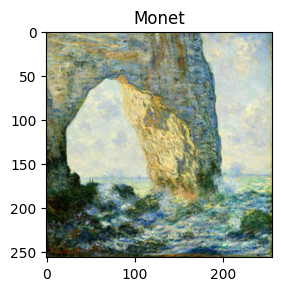

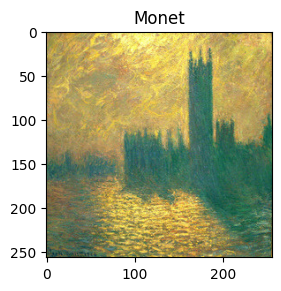

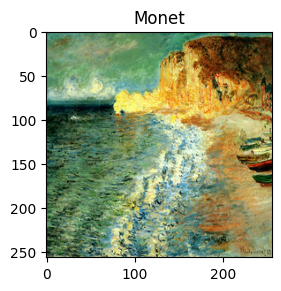

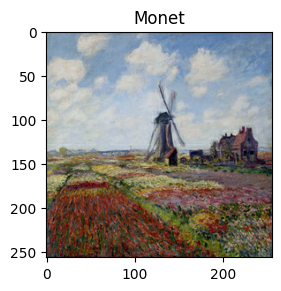

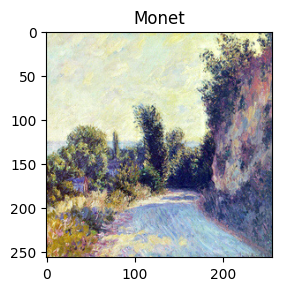

In [7]:
mds = iter(monet_ds)
a = 0
for elem in mds:
    if a>4:
        break
    plt.subplot(121)
    plt.title('Monet')
    plt.imshow(np.squeeze(elem) * 0.5 + 0.5)
    plt.show()
    a = a + 1

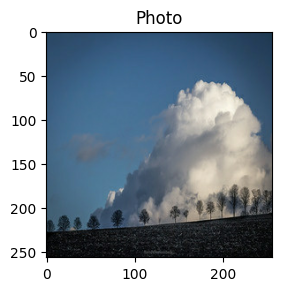

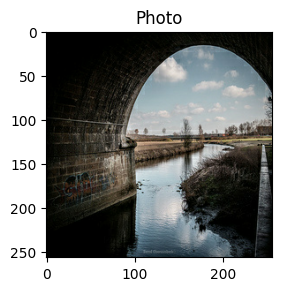

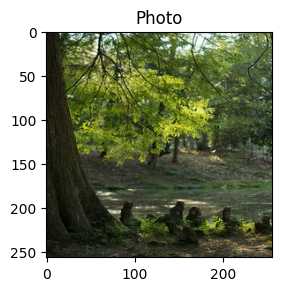

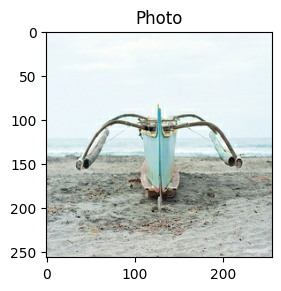

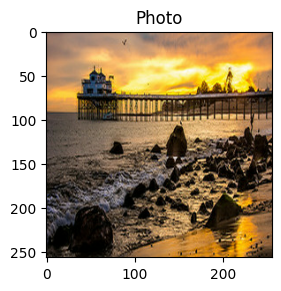

In [8]:
pds = iter(photo_ds)
a=0
for elem in pds:
    if a>4:
        break
    plt.subplot(121)
    plt.title('Photo')
    plt.imshow(np.squeeze(elem) * 0.5 + 0.5)
    plt.show()
    a = a + 1

# **Model Construction**

For the initial part of my model construction, I followed the tutorial on the main Kaggle competition page (Reference 1). This included code on how to create the autoencoder using upsampling and downsampling, how to creator a generator model, how to create a discriminator model, and how to define the loss functions and optimization parameters for each. 

In this GAN architecture, the generator and discriminator models essentially compete with one another. The generator tries to generate Monet-style images as realistically as possible, and the discriminator tries to catch which pictures are real or not. Over the course of the different training epochs, the generator and discriminator model weights are optimized, essentially becoming 'smarter' through this iterative competition.

Building upon the code base provided in the project tutorial, I created my own additional hyperparameter tuning experiment. More specifically, I investigated how varying the lambda cycle parameter would influence the accuracy of the complementary generator and discriminator models. Per Reference 4, the lambda cycle parameter limits the number of times a generator can translate images between domains for each training cycle. The example tutorial provided in the competition prompt set the value to 10 by default. No explanation was provided why. I tested 10, 5, 15, and 20 as possible lambda cycle values.

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [11]:
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [13]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
    
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
with strategy.scope():
    cycle_gan_model1 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )



# **Model 1 - Default Lambda = 10**

In [14]:
#default lambda_cycle value is 10 unless defined otherwise
with strategy.scope():
    cycle_gan_model1 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model1.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# **Model 2 - Lambda = 5**

In [15]:
with strategy.scope():
    cycle_gan_model2 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle = 5 #NOTE LAMBDA CYCLE DEFINITION HERE
    )

    cycle_gan_model2.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# **Model 3 - Lambda = 15**

In [16]:
with strategy.scope():
    cycle_gan_model3 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle = 15 #NOTE LAMBDA CYCLE DEFINITION HERE
    )

    cycle_gan_model3.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# **Model 4 - Lambda = 20**

In [17]:
with strategy.scope():
    cycle_gan_model4 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle = 20 #NOTE LAMBDA CYCLE DEFINITION HERE
    )

    cycle_gan_model4.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

print(cycle_gan_model1.lambda_cycle)
print(cycle_gan_model2.lambda_cycle)
print(cycle_gan_model3.lambda_cycle)
print(cycle_gan_model4.lambda_cycle)


# **Results and Analysis**

After creating the four different models with varied lambda cycle parameters, I trained them on the same Monet and Photograph data sets. Since the CycleGAN essentially is comprised of two models (generator and discriminator) and two data sets (Monet and Photograph), there were four different loss variables to track over the course of the different training epochs. While all of the different model configurations showed decreasing loss over the training epochs (with some noise, but the trend was clearly declining), they declined at different rates and ended up at different points.

Interestingly, the losses plots when overlayed stacked up on each other either in the order of 5, 10, 15, 20 or 20, 15, 10, 5. With lower loss being better, the lower lambda cycle values performed better with the generative models and the higher lambda cycles performed better with the discriminator models. This makes some sense upon reflection because the lambda cycle value does contribute to the net balancing of the competing generative and discriminator models.

While the higher lambda values performed somewhat better for the discriminator loss curves, the lowest lambda value performed significantly better for both the Monet and the photograph generative tasks. Therefore, to minimize total loss, I selected the model with the lambda=5 value as my final model for the competition.

In [19]:
cycle_gan_model1.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)


Epoch 1/10


2023-12-04 00:17:52.213160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 140s 253ms/step - monet_gen_loss: 5.1853 - photo_gen_loss: 5.3652 - monet_disc_loss: 0.6458 - photo_disc_loss: 0.6262
Epoch 2/10
300/300 [==============================] - 76s 251ms/step - monet_gen_loss: 3.6213 - photo_gen_loss: 3.7260 - monet_disc_loss: 0.6600 - photo_disc_loss: 0.6282
Epoch 3/10
300/300 [==============================] - 76s 251ms/step - monet_gen_loss: 3.5625 - photo_gen_loss: 3.6928 - monet_disc_loss: 0.6533 - photo_disc_loss: 0.6117
Epoch 4/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 3.4320 - photo_gen_loss: 3.5668 - monet_disc_loss: 0.6496 - photo_disc_loss: 0.6164
Epoch 5/10
300/300 [==============================] - 76s 251ms/step - monet_gen_loss: 3.2810 - photo_gen_loss: 3.4045 - monet_disc_loss: 0.6394 - photo_disc_loss: 0.6155
Epoch 6/10
300/300 [==============================] - 76s 251ms/step - monet_gen_loss: 3.1996 - photo_gen_loss: 3.2793 - monet_disc_loss: 0.6261 - photo_di

In [20]:
cycle_gan_model2.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)


Epoch 1/10


2023-12-04 00:31:15.308317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 103s 250ms/step - monet_gen_loss: 2.0135 - photo_gen_loss: 2.0473 - monet_disc_loss: 0.6553 - photo_disc_loss: 0.6538
Epoch 2/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 1.9842 - photo_gen_loss: 2.0181 - monet_disc_loss: 0.6482 - photo_disc_loss: 0.6511
Epoch 3/10
300/300 [==============================] - 76s 251ms/step - monet_gen_loss: 1.9699 - photo_gen_loss: 2.0135 - monet_disc_loss: 0.6507 - photo_disc_loss: 0.6473
Epoch 4/10
300/300 [==============================] - 77s 253ms/step - monet_gen_loss: 1.9574 - photo_gen_loss: 2.0042 - monet_disc_loss: 0.6523 - photo_disc_loss: 0.6491
Epoch 5/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 1.9294 - photo_gen_loss: 1.9847 - monet_disc_loss: 0.6550 - photo_disc_loss: 0.6490
Epoch 6/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 1.9100 - photo_gen_loss: 1.9694 - monet_disc_loss: 0.6570 - photo_di

In [21]:
cycle_gan_model3.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)


Epoch 1/10


2023-12-04 00:44:23.866263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 102s 250ms/step - monet_gen_loss: 3.7996 - photo_gen_loss: 3.9258 - monet_disc_loss: 0.5966 - photo_disc_loss: 0.5724
Epoch 2/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 3.6903 - photo_gen_loss: 3.8054 - monet_disc_loss: 0.6000 - photo_disc_loss: 0.5689
Epoch 3/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 3.6253 - photo_gen_loss: 3.7505 - monet_disc_loss: 0.6034 - photo_disc_loss: 0.5682
Epoch 4/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 3.6109 - photo_gen_loss: 3.7380 - monet_disc_loss: 0.6004 - photo_disc_loss: 0.5668
Epoch 5/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 3.5777 - photo_gen_loss: 3.7137 - monet_disc_loss: 0.6066 - photo_disc_loss: 0.5680
Epoch 6/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 3.5722 - photo_gen_loss: 3.7103 - monet_disc_loss: 0.6064 - photo_di

In [22]:
cycle_gan_model4.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)


Epoch 1/10


2023-12-04 00:57:31.858963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 103s 250ms/step - monet_gen_loss: 4.2359 - photo_gen_loss: 4.4257 - monet_disc_loss: 0.5915 - photo_disc_loss: 0.5519
Epoch 2/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 4.2881 - photo_gen_loss: 4.4599 - monet_disc_loss: 0.5738 - photo_disc_loss: 0.5342
Epoch 3/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 4.2515 - photo_gen_loss: 4.4952 - monet_disc_loss: 0.5786 - photo_disc_loss: 0.5223
Epoch 4/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 4.1395 - photo_gen_loss: 4.3438 - monet_disc_loss: 0.5914 - photo_disc_loss: 0.5501
Epoch 5/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 4.1208 - photo_gen_loss: 4.3003 - monet_disc_loss: 0.5871 - photo_disc_loss: 0.5490
Epoch 6/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 4.0670 - photo_gen_loss: 4.2420 - monet_disc_loss: 0.5897 - photo_di

In [23]:
print(cycle_gan_model4.history.history.keys())
#print(cycle_gan_model4.history.history['monet_gen_loss'])
print(cycle_gan_model4.history.history['photo_gen_loss'])

#I was getting an array of lists when I tried to pull the history of the models, 
#so I eventually figured it would be faster to just manually enter for the plots
mgl4 = [4.3190, 4.2101, 4.1699, 4.1379, 4.1047, 4.1829, 4.0354, 4.1645, 4.0520]
pgl4 = [4.4838, 4.3737, 4.3325, 4.2656, 4.2934, 4.3747, 4.2233, 4.4063, 4.2325]
mdl4 = [0.5878, 0.5887, 0.5925, 0.5877, 0.5923, 0.5833, 0.5918, 0.5800, 0.5886]
pdl4 = [0.5558, 0.5642, 0.5668, 0.5658, 0.5591, 0.5467, 0.5603, 0.5302, 0.5530]

mgl3 = [3.7384, 3.6290, 3.5976, 3.5663, 3.4853, 3.4610, 3.4903, 3.4237]
pgl3 = [3.8876, 3.7578, 3.7156, 3.6926, 3.6511, 3.5977, 3.6167, 3.5763]
mdl3 = [0.6047, 0.6104, 0.6088, 0.6107, 0.6134, 0.6139, 0.6071, 0.6161]
pdl3 = [0.5749, 0.5801, 0.5817, 0.5848, 0.5799, 0.5890, 0.5847, 0.5814]

mgl2 = [2.2057, 1.9924, 1.9627, 1.9447, 1.8937, 1.8708, 1.8510, 1.8396, 1.8217]
pgl2 = [2.0521, 2.0206, 1.9981, 1.9816, 1.9462, 1.9249, 1.9132, 1.9009, 1.8886]
mdl2 = [0.6565, 0.6532, 0.6555, 0.6517, 0.6591, 0.6613, 0.6620, 0.6627, 0.6639]
pdl2 = [0.6540, 0.6506, 0.6505, 0.6491, 0.6510, 0.6537, 0.6513, 0.6514, 0.6534]

mgl1 = [5.2379, 3.6377, 3.5414, 3.3606, 3.2231, 3.1793, 3.1611, 3.1401, 3.1343, 3.1278]
pgl1 = [5.4188, 3.7260, 3.6308, 3.4744, 3.3667, 3.3104, 3.2513, 3.2078, 3.1785, 3.1550]
mdl1 = [0.6429, 0.6602, 0.6602, 0.6526, 0.6431, 0.6301, 0.6238, 0.6203, 0.6129, 0.6088]
pdl1 = [0.6217, 0.6415, 0.6530, 0.6180, 0.6056, 0.6032, 0.6124, 0.6107, 0.6114, 0.6121]

dict_keys(['monet_gen_loss', 'photo_gen_loss', 'monet_disc_loss', 'photo_disc_loss'])


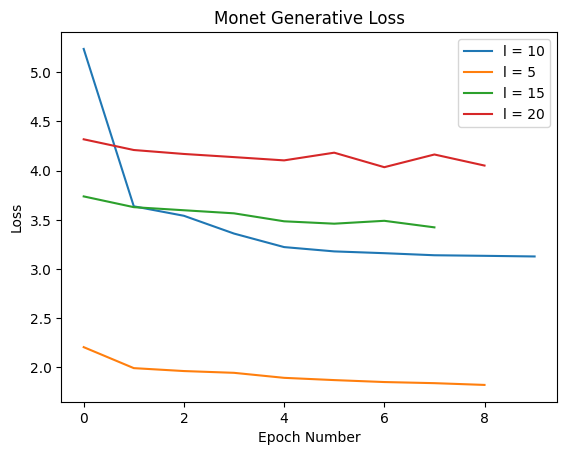

In [24]:
plt.plot(mgl1)
plt.plot(mgl2)
plt.plot(mgl3)
plt.plot(mgl4)
plt.title('Monet Generative Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend(['l = 10','l = 5', 'l = 15', 'l = 20'])

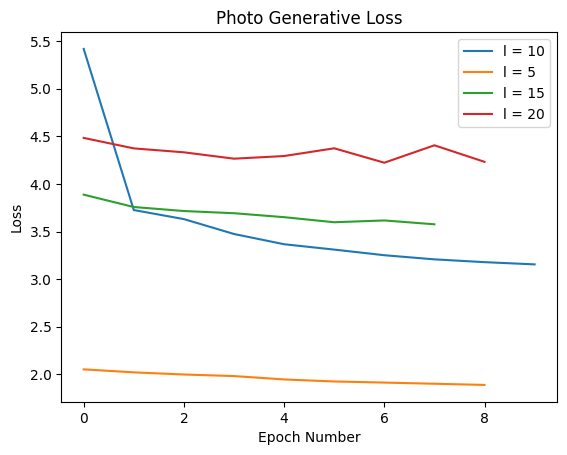

In [25]:
plt.plot(pgl1)
plt.plot(pgl2)
plt.plot(pgl3)
plt.plot(pgl4)
plt.title('Photo Generative Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend(['l = 10','l = 5', 'l = 15', 'l = 20'])

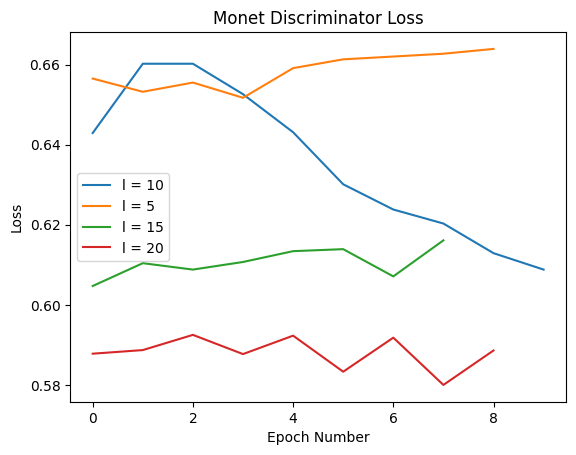

In [26]:
plt.plot(mdl1)
plt.plot(mdl2)
plt.plot(mdl3)
plt.plot(mdl4)
plt.title('Monet Discriminator Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend(['l = 10','l = 5', 'l = 15', 'l = 20'])

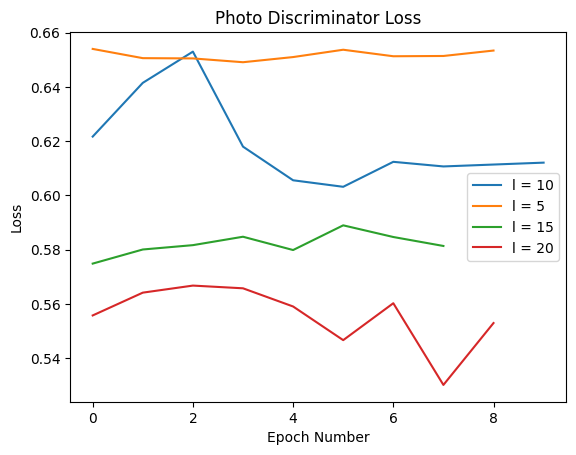

In [27]:
plt.plot(pdl1)
plt.plot(pdl2)
plt.plot(pdl3)
plt.plot(pdl4)
plt.title('Photo Discriminator Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend(['l = 10','l = 5', 'l = 15', 'l = 20'])

In [28]:
#Since the generator and discriminator models are modified by the training, I'm redoing the training one more time using the l=5 parameter from the second model
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle = 5
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)


Epoch 1/10


2023-12-04 01:10:38.096510: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 100s 250ms/step - monet_gen_loss: 1.7362 - photo_gen_loss: 1.8783 - monet_disc_loss: 0.6578 - photo_disc_loss: 0.6049
Epoch 2/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 1.6955 - photo_gen_loss: 1.8252 - monet_disc_loss: 0.6618 - photo_disc_loss: 0.6261
Epoch 3/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 1.6762 - photo_gen_loss: 1.7965 - monet_disc_loss: 0.6583 - photo_disc_loss: 0.6270
Epoch 4/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 1.6705 - photo_gen_loss: 1.7781 - monet_disc_loss: 0.6565 - photo_disc_loss: 0.6290
Epoch 5/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 1.6805 - photo_gen_loss: 1.7798 - monet_disc_loss: 0.6535 - photo_disc_loss: 0.6307
Epoch 6/10
300/300 [==============================] - 76s 250ms/step - monet_gen_loss: 1.6780 - photo_gen_loss: 1.7676 - monet_disc_loss: 0.6538 - photo_di

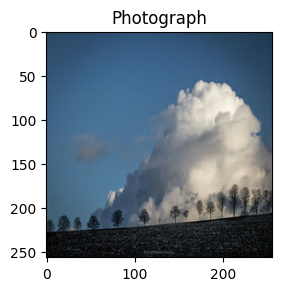

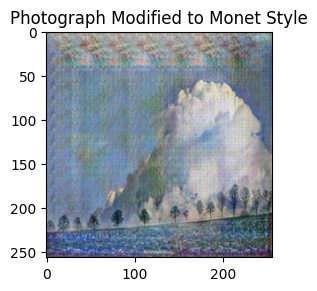

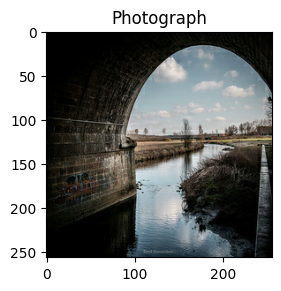

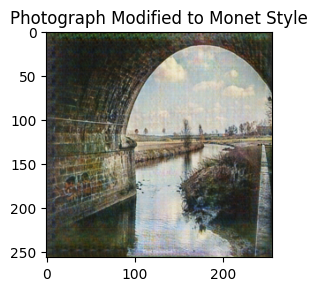

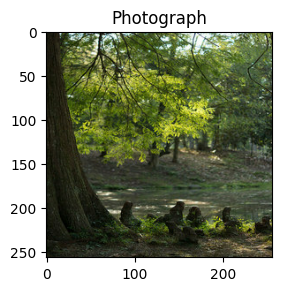

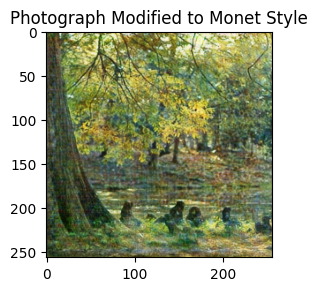

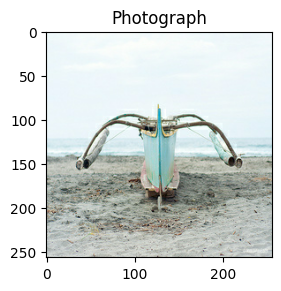

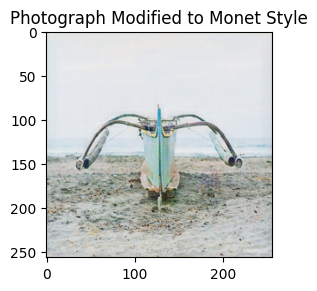

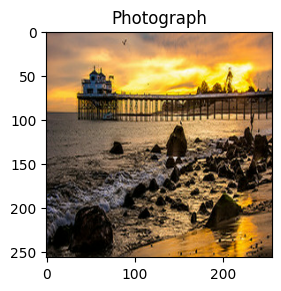

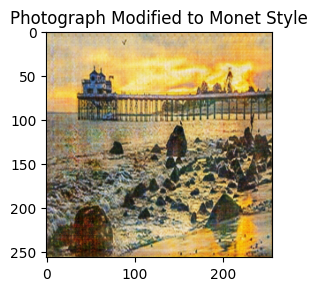

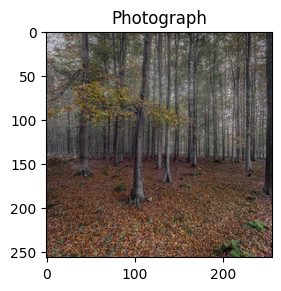

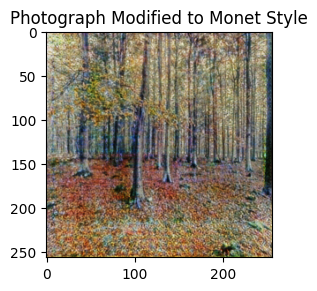

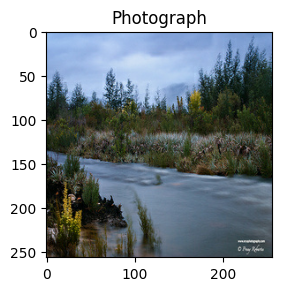

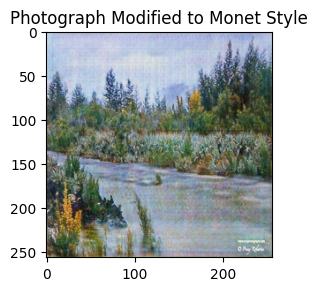

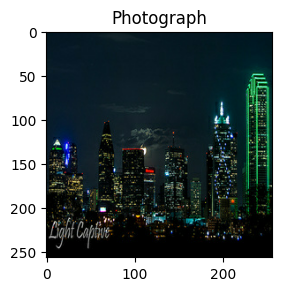

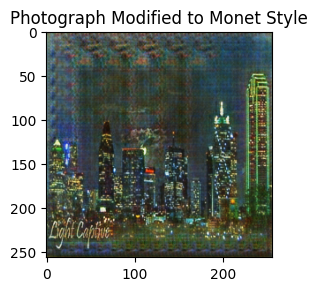

In [61]:


for i, img in enumerate(photo_ds.take(8)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    plt.subplot(121)
    plt.title('Photograph')
    plt.imshow(img)
    plt.show()
    
    plt.subplot(121)
    plt.title('Photograph Modified to Monet Style')
    plt.imshow(prediction)
    plt.show()

# **Discussion and Conclusion**

By picking a lambda value of 5 (as opposed to 10 in the Kaggle-provided tutorial), I was able to almost halve the loss associated with the generative part of the CycleGAN with a minimal (5%) impact to the discriminator part of the CycleGAN. Overall, the results visibly do resemble the work of Monet.

If I were to continue this work further, I would try to experiment with tuning other hyperparameters in the CycleGAN setup. Another idea I had was to create multiple generative models and multiple discriminator models for the competition. So instead of just having one generator competing with a discriminator, the generators would compete against each other and the discriminators would compete against each other before then pairing the generator with the discriminator. That might not work, but it was an idea I had while I was thinking about this project.

Another thing I would seek to improve on is the fact that I was unable to submit my predictions to the competition. When I tried to generate all the predictions and archive the files into a zip folder per the code instructions in the tutorial, I got an error about the directory not having enough storage space. I think that may have been because I chose the GPU100 accelerator architecture. While that made the model training faster, it limited some of the other computing specs. I don't want to pay for Google AI Notebooks. That caused the submission reader to fail to find the .zip file. I still think visually, my predictions were good. It's just that the submission part didn't work. I spend more than an hour unsuccessfully debugging. If I were to keep working at this project, that is something I'd continue trying to improve on.

In [59]:
! mkdir /kaggle/working/
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(str(i) + ".jpg")
    i = i + 1
    #"".../images/" + 
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working")
#shutil.make_archive("/kaggle/working/", 'zip', "/kaggle/working/")

mkdir: cannot create directory ‘/kaggle/working/’: File exists


OSError: [Errno 28] No space left on device

# **References:**
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
-- As referenced above, I used parts of the recommended Kaggle-provided tutorial, which I then built on myself to perform hyperparameter tuning of the lambda variable.
- https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
- https://www.kaggle.com/competitions/gan-getting-started
- https://www.andrew.cmu.edu/course/16-726/projects/rhaber/proj3/